# Autoencoders

В этом ноутбуке мы будем тренировать автоэнкодеры кодировать лица людей. Для этого возьмем следующий датасет: "Labeled Faces in the Wild" (LFW) (http://vis-www.cs.umass.edu/lfw/). Код для скачивания и загрузки датасета написан за вас в файле get_dataset.py


# Vanilla Autoencoder (2 балла)  ----  done

## Prepare the data


In [1]:
import os
import skimage.io
import numpy as np
import pandas as pd
from skimage.transform import resize

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils

from torch.autograd import Variable
from IPython.display import clear_output
from torch.utils.data import Dataset, DataLoader


import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

In [2]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=45,dimy=45
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,) 
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    # print(df.shape)
    #image preprocessing
    print('image preprocessing...')
    all_photos =df['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))
    print('done')

    all_photos = np.stack(all_photos.values)#.astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)
    
    return all_photos, all_attrs
    

In [3]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind
#from get_dataset import fetch_dataset
data, attrs = fetch_dataset()

images not found, donwloading...
extracting...
done
attributes not found, downloading...
done
image preprocessing...
done



Разбейте выборку картинок на train и val, выведите несколько картинок в output, чтобы посмотреть, как они выглядят, и приведите картинки к тензорам pytorch, чтобы можно было скормить их сети:

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [5]:
data = data.transpose((0, 3, 1, 2))
data.shape

(13143, 3, 45, 45)

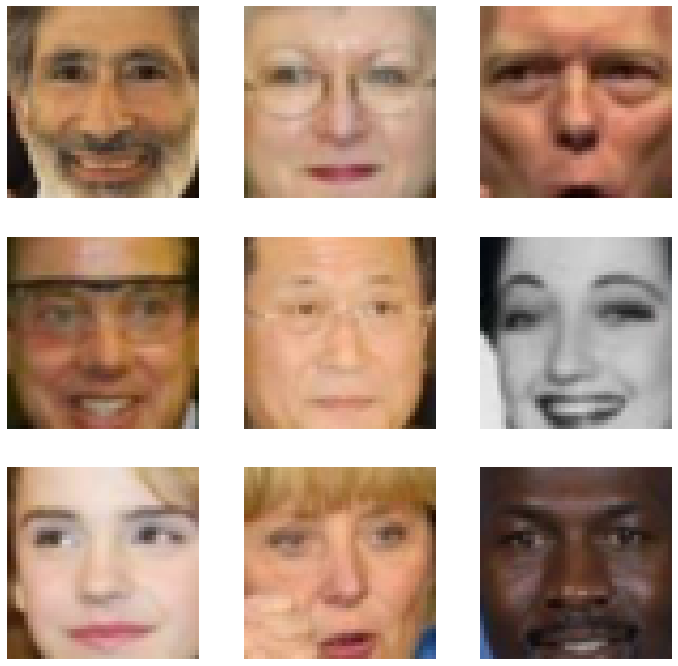

In [6]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0, 13143))
    image = data[random_characters].transpose((1, 2, 0))
    fig_x.axis('off')
    fig_x.imshow(image)

In [7]:
from sklearn.model_selection import train_test_split

batch_size = 256

train_data, val_data = train_test_split(data, test_size=0.33)
train_data.shape, val_data.shape

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)

```
# This is formatted as code
```

## Autoencoder  ----  done
В этом разделе мы напишем и обучем обычный автоэнкодер.

Надеюсь, что к этому моменту вы уже почитали про автоэнкодеры и знаете, зачем они нужны и какова их архитектура. Если нет, то начните с этих ссылок: 

https://habr.com/ru/post/331382/ \\
https://towardsdatascience.com\intuitively-understanding-variational-autoencoders-1bfe67eb5daf



<img src="https://i.imgur.com/nVJAtMT.png" alt="Autoencoder">

^ вот так выглядит автоэнкодер

Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэекодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

In [8]:
def train(model, opt, loss_fn, epochs, data_tr, data_val, device):
    train_loss = []
    val_loss = []

    for epoch in range(epochs):
        print('* Epoch %d/%d' % (epoch+1, epochs))

        epoch_loss = 0
        model.train()  # train mode
        for images in data_tr:
            images = images.float().to(device)
            # set parameter gradients to zero
            opt.zero_grad()
            # forward
            Y_pred = model(images)
            loss = loss_fn(Y_pred, images) # forward-pass
            
            loss.backward() # backward-pass
            opt.step()  # update weights

            # calculate loss to show the user
            epoch_loss += loss.item()*images.size(0)
        avg_loss = epoch_loss/len(data_tr)
        train_loss.append(avg_loss)

        model.eval()  # testing mode
        image_val = next(iter(data_val)).float().to(device)
        prediction = model(image_val)
        v_loss = loss_fn(prediction, image_val).item()*image_val.size(0)
        val_loss.append(v_loss)

        print('train_loss: %f' % avg_loss, 'val_loss: %f' % v_loss)

        # Visualize tools
        if (epoch + 1) % 10 == 0:
          clear_output(wait=True)

          real = image_val.cpu().detach().numpy().transpose((0, 2, 3, 1))
          pred = prediction.cpu().detach().numpy().transpose((0, 2, 3, 1))

          fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(8, 8), sharey=True, sharex=True)
          for i, fig_x in enumerate(ax.flatten()):
            real_img = real[i]
            fig_x.axis('off')
            fig_x.set_title('real')
            fig_x.imshow(real_img)
          
          fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(8, 8), sharey=True, sharex=True)
          for i, fig_x in enumerate(ax.flatten()):
            pred_img = pred[i]
            fig_x.axis('off')
            fig_x.set_title('predicted')
            fig_x.imshow(pred_img)

          plt.figure(figsize=(8, 5))
          plt.plot(train_loss, label="train_loss")
          plt.plot(val_loss, label="val_loss")
          plt.legend(loc='best')
          plt.xlabel("epochs")
          plt.ylabel("loss")
          plt.show()
 

In [9]:
from copy import deepcopy

class LINAutoencoder(nn.Module):
  def __init__(self):
    super(LINAutoencoder, self).__init__()

    self.encoder = nn.Sequential(
        nn.Flatten(),
        nn.Linear(6075, 4000), 
        nn.LeakyReLU(0.02),
        nn.Linear(4000, 2000), 
        nn.LeakyReLU(0.02),
        nn.Linear(2000, 300), 
        nn.LeakyReLU(0.02),
        )

    self.decoder = nn.Sequential(
        nn.Linear(300, 2000), 
        nn.LeakyReLU(0.02),
        nn.Linear(2000, 4000), 
        nn.LeakyReLU(0.02),
        nn.Linear(4000, 6075), 
        nn.Sigmoid()
    )

  def forward(self, x):
    m = x.shape
    x = self.encoder(x)
    x = self.decoder(x)

    return x.reshape(m)

In [10]:
criterion = nn.MSELoss()
autoencoder= LINAutoencoder().to(device)

In [12]:
img = next(iter(val_loader))
img = img.float().to(device)
print(img.shape)
print(autoencoder(img).shape)

torch.Size([256, 3, 45, 45])
torch.Size([256, 3, 45, 45])


In [13]:
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.0001)

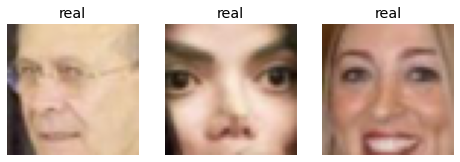

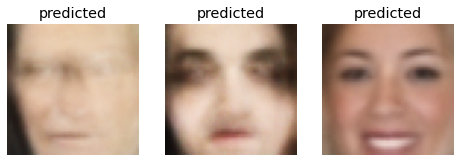

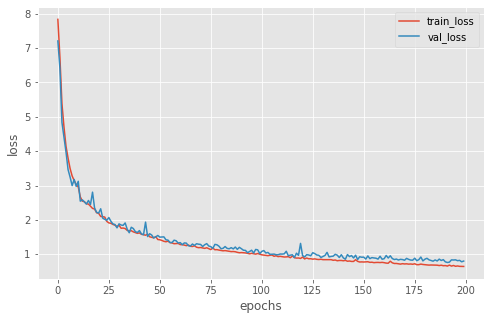

In [14]:
train(autoencoder, optimizer, criterion, 200, train_loader, val_loader, device)

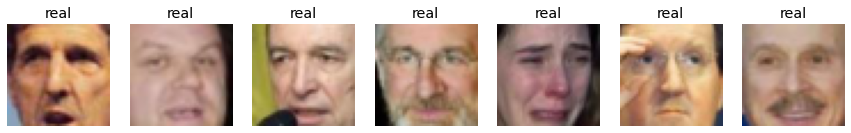

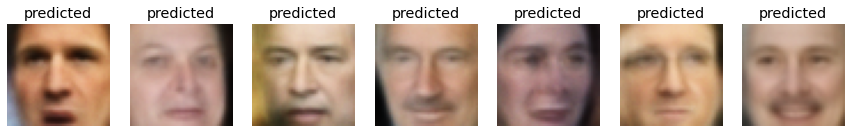

In [15]:
autoencoder.eval()
real = next(iter(val_loader))
pred = autoencoder(real.float().to(device)).cpu().detach().numpy().transpose((0, 2, 3, 1))
real = real.numpy().transpose((0, 2, 3, 1))

fig, ax = plt.subplots(nrows=1, ncols=7,figsize=(15, 15), sharey=True, sharex=True)
for i, fig_x in enumerate(ax.flatten()):
      real_img = real[i]
      fig_x.axis('off')
      fig_x.set_title('real')
      fig_x.imshow(real_img)
          
fig, ax = plt.subplots(nrows=1, ncols=7,figsize=(15, 15), sharey=True, sharex=True)
for i, fig_x in enumerate(ax.flatten()):
      pred_img = pred[i]
      fig_x.axis('off')
      fig_x.set_title('predicted')
      fig_x.imshow(pred_img)

Not bad, right? 

## Sampling

Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

#### If that doesn't work
Если вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как np.random.randn(25, <latent_space_dim>). А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как лаьентные векторы реальных фоток. Так что ридется рандом подогнать.

In [25]:
X = next(iter(val_loader)).float().to(device)
enc = autoencoder.encoder(X).cpu().detach().numpy()

k = np.random.randint(0, 256)
mu = enc.mean(axis=1)[:256]
sigma = enc.std(axis=1)[:256]

In [26]:
mu.shape

(256,)

In [33]:
vector = []
for i in range(256):
  dist = np.random.normal(mu[i], sigma[i], 300)
  vector.append(dist)

vector = np.array(vector) 

In [35]:
vector.shape

(256, 300)

In [37]:
# сгенерируем 25 рандомных векторов размера latent_space
z = np.random.randn(25, 300) 
z = torch.Tensor(vector).to(device)
output = autoencoder.decoder(z).cpu().detach().numpy().reshape((256, 3, 45, 45)).transpose((0, 2, 3, 1))

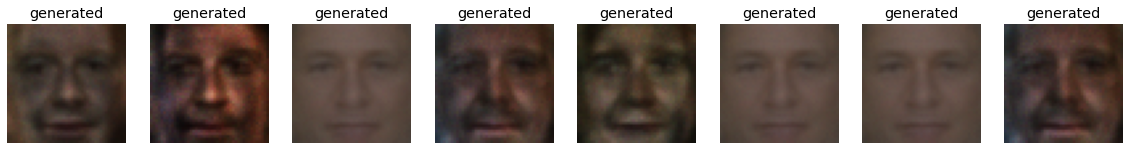

In [38]:
fig, ax = plt.subplots(nrows=1, ncols=8,figsize=(20, 20), sharey=True, sharex=True)
for i, fig_x in enumerate(ax.flatten()):
      random_characters = int(np.random.uniform(0, 25))
      pred_img = output[random_characters]
      fig_x.axis('off')
      fig_x.set_title('generated')
      fig_x.imshow(pred_img)

## Congrats!

Time to make fun!

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

План такой:

1) Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15 сойдет) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с описанием датасета, скачанный вместе с датасетом. В нем указаны имена картинок и присутствубщие атрибуты (улыбки, очки...)

2) Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3) Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

3) А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного чувака и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

In [ ]:
attrs

,Male,Asian,White,Black,Baby,Child,Youth,Middle Aged,Senior,Black Hair,Blond Hair,Brown Hair,Bald,No Eyewear,Eyeglasses,Sunglasses,Mustache,Smiling,Frowning,Chubby,Blurry,Harsh Lighting,Flash,Soft Lighting,Outdoor,Curly Hair,Wavy Hair,Straight Hair,Receding Hairline,Bangs,Sideburns,Fully Visible Forehead,Partially Visible Forehead,Obstructed Forehead,Bushy Eyebrows,Arched Eyebrows,Narrow Eyes,Eyes Open,Big Nose,Pointy Nose,Big Lips,Mouth Closed,Mouth Slightly Open,Mouth Wide Open,Teeth Not Visible,No Beard,Goatee,Round Jaw,Double Chin,Wearing Hat,Oval Face,Square Face,Round Face,Color Photo,Posed Photo,Attractive Man,Attractive Woman,Indian,Gray Hair,Bags Under Eyes,Heavy Makeup,Rosy Cheeks,Shiny Skin,Pale Skin,5 o' Clock Shadow,Strong Nose-Mouth Lines,Wearing Lipstick,Flushed Face,High Cheekbones,Brown Eyes,Wearing Earrings,Wearing Necktie,Wearing Necklace
0,1.56835,-1.88904,1.7372,-0.929729,-1.4718,-0.19558,-0.835609,-0.351468,-1.01253,-0.719593,-0.632401,0.464839,-0.973528,1.56519,-1.2967,-1.54272,-0.684671,-0.86499,0.766886,-0.218952,-1.65567,-0.787044,-0.599665,0.458519,0.18976,0.851555,-0.38572,-0.497719,-0.161149,-0.257514,-0.0888388,0.455469,-0.839211,-0.0229481,-0.922568,-0.114539,1.46122,1.75848,0.0688935,1.26786,-1.12024,0.917617,-1.30796,-1.50041,1.02922,0.832363,-0.498657,0.251365,-0.705281,-0.515715,0.374239,-0.168675,-0.614143,3.0977,1.52386,0.779278,-0.0714539,-1.24648,-0.769283,-0.725597,-1.82061,-2.07298,-0.960759,0.361738,1.16612,-1.16492,-1.13999,-2.37175,-1.29993,-0.414682,-1.1449,0.694007,-0.826609
1,0.169851,-0.982408,0.422709,-1.28218,-1.36006,-0.867002,-0.452293,-0.197521,-0.956073,-0.802107,-0.736883,0.294554,-1.27765,0.954771,-0.990992,-1.16736,-0.835146,0.798544,-0.971679,0.342826,-1.32256,0.962937,-1.19936,-0.157307,0.443224,-0.00288156,-0.0211584,-0.226563,-0.0810386,-0.827202,-0.106624,1.22759,-0.812223,-1.24126,0.0962725,-0.404544,0.325919,0.474452,1.13536,0.0587247,0.611176,-1.17251,0.428512,-0.874235,-1.19156,0.192359,-0.204166,0.342347,0.239512,-1.47469,0.236057,-0.565208,-0.712542,2.99708,-0.273306,-0.187722,-0.604608,-1.3217,-0.938559,0.494294,-0.659043,-1.14375,-0.775722,-0.832036,-0.39768,0.87416,-0.945431,-0.268649,-0.00624408,-0.0304057,-0.480128,0.66676,-0.496559
2,0.997749,-1.36419,-0.157377,-0.756447,-1.89183,-0.871526,-0.862893,0.0314447,-1.34152,-0.0900375,-1.20073,-0.33246,-0.537006,1.29836,-1.49847,-1.28582,1.14174,0.172817,0.106412,-0.788843,0.349295,-1.64372,0.454287,1.18946,-0.688414,-0.590574,-0.266673,0.467224,0.567348,-1.7191,0.124667,1.60274,-0.659399,-1.75376,1.20447,0.0221884,-1.13544,1.70286,-0.422144,0.587859,0.414363,0.344447,-1.26045,-0.577746,0.405567,-1.91655,0.92126,0.247437,-0.428451,-0.772273,0.370673,-0.509596,-0.768482,1.7069,0.126524,-0.497001,-0.393042,-0.178307,-1.18023,-0.596914,-1.80538,-0.951643,-0.838087,1.54974,1.88475,-0.999765,-1.35986,-1.91211,-1.09563,0.915126,-0.572332,0.144262,-0.841231
3,1.12272,-1.9978,1.91614,-2.51421,-2.58007,-1.40424,0.0575511,0.000195882,-1.27351,-1.43146,-0.0705188,-0.339239,-2.00415,0.665695,-0.77594,-1.47163,-1.17908,0.563327,-0.664429,-1.40793,0.435594,-0.589988,-1.6035,1.17074,0.760103,0.211498,-0.51618,-1.33115,0.20284,0.149645,-0.0464296,0.640885,-0.107616,-0.831271,-0.827005,-0.588725,0.429255,1.58766,0.499086,-0.0568692,-0.866643,-0.959689,0.35073,-1.33535,-0.42789,0.826817,-0.256779,0.149751,-1.20153,-1.08392,0.255363,-0.650423,-0.506293,1.10159,0.640783,1.57503,-0.484397,-1.55968,-1.43712,0.379363,-0.648233,-2.25735,-1.07561,0.567822,-0.176089,1.10812,-1.60094,-3.26461,0.813418,0.308631,-0.848693,0.475941,-0.447025
4,1.07821,-2.0081,1.67621,-2.27806,-2.65185,-1.34841,0.649089,0.0176564,-1.88911,-1.85721,-0.568057,0.840375,-1.98127,1.66671,-0.910723,-1.99351,-0.871335,0.507786,-0.488947,-0.88649,-0.990132,-0.750813,-0.378479,0.583086,-1.4796,0.250185,-0.381123,-0.611991,-0.143091,-1.07276,0.432094,1.08919,-0.470929,-1.17712,-0.111313,-0.154603,-1.03151,2.39246,-0.191576,1.2279,-1.3818,-1.52885,0.907964,-1.32429,-0

In [ ]:
smiles = attrs['Smiling'].sort_values(ascending=False)[0: 16]
sad = attrs['Smiling'].sort_values(ascending=True)[0: 16]
smiling_faces = smiles.index.tolist()
sad_faces = sad.index.tolist()

In [ ]:
# Скорректируем эмоцию только для женщин 
smiles = attrs['Smiling'].sort_values(ascending=False)[0: 16]
sad = attrs.Smiling[attrs['Male'] < -2].sort_values(ascending=True)[0: 16]
smiling_faces = smiles.index.tolist()
sad_faces = sad.index.tolist()

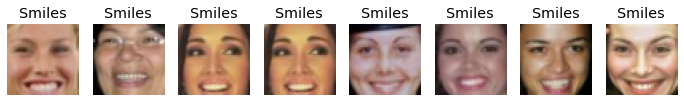

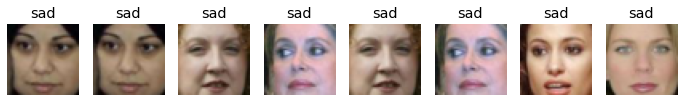

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=8,figsize=(12, 12), sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = np.random.choice(smiling_faces)
    image = data[random_characters].transpose((1, 2, 0))
    fig_x.axis('off')
    fig_x.set_title("Smiles")
    fig_x.imshow(image)

fig, ax = plt.subplots(nrows=1, ncols=8,figsize=(12, 12), sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = np.random.choice(sad_faces)
    image = data[random_characters].transpose((1, 2, 0))
    fig_x.axis('off')
    fig_x.set_title("sad")
    fig_x.imshow(image)

In [ ]:
smile_tensor = torch.Tensor(data[smiling_faces]).float().to(device)
smile_enc = autoencoder.encoder(smile_tensor).mean(axis=0)
sad_tensor = torch.Tensor(data[sad_faces]).float().to(device)
sad_enc = autoencoder.encoder(sad_tensor).mean(axis=0)

In [ ]:
alpha = 1#0.7
beta = 1#0.7
smiler = smile_enc - sad_enc * beta 

output = autoencoder.decoder(autoencoder.encoder(sad_tensor) + alpha * smiler).reshape(16, 3, 45, 45)

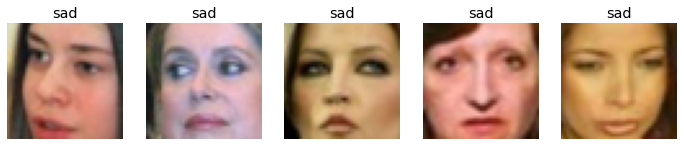

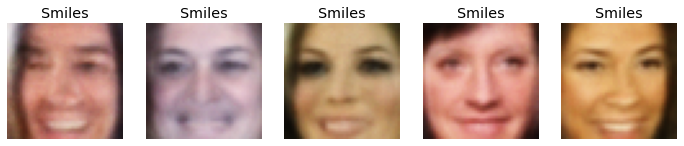

In [ ]:
sad_base = sad_tensor.cpu().detach().numpy().transpose((0, 2, 3, 1))
smile_base = output.cpu().detach().numpy().transpose((0, 2, 3, 1))
random_characters = np.random.randint(0, 16, 5,)

fig, ax = plt.subplots(nrows=1, ncols=5,figsize=(12, 12), sharey=True, sharex=True)
for i, fig_x in zip(random_characters, ax.flatten()):
    image = sad_base[i]
    fig_x.axis('off')
    fig_x.set_title("sad")
    fig_x.imshow(image)


fig, ax = plt.subplots(nrows=1, ncols=5,figsize=(12, 12), sharey=True, sharex=True)
for i, fig_x in zip(random_characters,ax.flatten()):
    image = smile_base[i]
    fig_x.axis('off')
    fig_x.set_title("Smiles")
    fig_x.imshow(image)

Вуаля! Вы восхитительны!

Теперь вы можете пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... в общем, все, на что хватит фантазии и на что есть атрибуты в lwf_deepfinetuned.txt =)

# Variational Autoencoder. (3 балла)  ----  done

Представляю вам проапгрейдженную версию автоэнкодеров -- вариационные автоэнкодеры.

https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf

In [ ]:
def MNISTshow(img, fig_x):
  img = img.reshape((28, 28))
  fig_x.axis('off')
  fig_x.imshow(img, cmap='gray')

In [ ]:
def trainMNIST(model, opt, loss_fn, epochs, data_tr, data_val, device):
    train_loss = []
    val_loss = []

    for epoch in range(epochs):
        model.train()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        epoch_loss = 0
        model.train()  # train mode

        for batch in data_tr:
            images, _ = batch
            images = images.to(device)
            # set parameter gradients to zero
            opt.zero_grad()
            # forward
            mu, logsigma, Y_pred = model(images)
            loss = loss_fn(images, mu, logsigma, Y_pred) # forward-pass
            
            loss.backward() # backward-pass
            opt.step()  # update weights

            # calculate loss to show the user
            epoch_loss += loss.item()
        avg_loss = epoch_loss/len(data_tr)
        train_loss.append(avg_loss)

        model.eval() 
        with torch.no_grad():  # testing mode
           image_val, _ = next(iter(data_val))
           image_val = image_val.to(device)

           mu, logsigma, prediction = model(image_val)
           v_loss = loss_fn(image_val, mu, logsigma, prediction).item()
           val_loss.append(v_loss)

        print('train_loss: %f' % avg_loss, 'val_loss: %f' % v_loss)

        # Visualize tools
        if  (epoch + 1) % 10 == 0:
          clear_output(wait=True)

          real = image_val.cpu().detach().numpy()
          pred = prediction.cpu().detach().numpy()

          k = int(np.random.randint(0, 50))

          fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(8, 8), sharey=True, sharex=True)
          for i, fig_x in enumerate(ax.flatten()):
            real_img = real[k + i]
            fig_x.set_title("real")
            MNISTshow(real_img, fig_x)
          
          fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(8, 8), sharey=True, sharex=True)
          for i, fig_x in enumerate(ax.flatten()):
            pred_img = pred[k + i]
            fig_x.set_title("predicted")
            MNISTshow(pred_img, fig_x)

          plt.figure(figsize=(8, 5))
          plt.plot(train_loss, label="train_loss")
          plt.plot(val_loss, label="val_loss")
          plt.legend(loc='best')
          plt.xlabel("epochs")
          plt.ylabel("loss")
          plt.show()
 

In [ ]:
class VAE(nn.Module):
    def __init__(self, latent_dim):
      super(VAE, self).__init__()
      self.latent = latent_dim

      self.encoder = nn.Sequential(
        nn.Flatten(),
        nn.Linear(784, 512), 
        nn.ReLU(),
        nn.Linear(512, self.latent*2), 
        #nn.Linear(256, 32), 
        #nn.ReLU(),
        )

      self.decoder = nn.Sequential(
        #nn.Linear(16, 256), 
        #nn.ReLU(),
        nn.Linear(self.latent, 512), 
        nn.ReLU(),
        nn.Linear(512, 784), 
        )


    def encode(self, x):
        x = self.encoder(x).view(-1, 2, self.latent)
        mu = x[:, 0, :]
        logsigma = x[:, 1, :] * 0.5
        
        return mu, logsigma
    
    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = torch.exp(logsigma)
            eps = torch.randn_like(std)
            sample = mu + (eps * std)
            return sample
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu. 
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu
    
    def decode(self, z):
        reconstruction = torch.sigmoid(self.decoder(z))
        
        return reconstruction

    def forward(self, x):
        m = x.shape
        mu, logsigma = self.encode(x)
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(z)

        return mu, logsigma, reconstruction.reshape(m)

In [ ]:
from torchvision import datasets
import torchvision.transforms as transforms

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])

In [ ]:
# train and validation data
train_data = datasets.MNIST(
    root='../input/data',
    train=True,
    download=True,
    transform=transform
)
val_data = datasets.MNIST(
    root='../input/data',
    train=False,
    download=True,
    transform=transform
)

train_loader_mnist = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader_mnist = DataLoader(val_data, batch_size=64, shuffle=False)

Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [ ]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    log_var = 2 * logsigma
    loss = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return loss

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
    loss = nn.BCELoss(reduction='sum')
    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):
    return   KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)

И обучим модель:

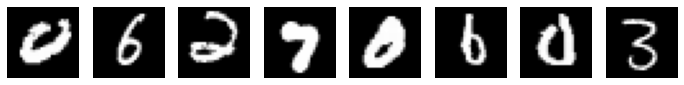

In [ ]:
img, _ = next(iter(train_loader_mnist))
k = int(np.random.randint(0, 50))

fig, ax = plt.subplots(nrows=1, ncols=8,figsize=(12, 12), sharey=True, sharex=True)
for i, fig_x in enumerate(ax.flatten()):
    image = img[k + i]
    MNISTshow(image, fig_x)

In [ ]:
latent_dim=16
criterion = loss_vae
vae = VAE(latent_dim=latent_dim).to(device)

In [ ]:
optimizer = torch.optim.Adam(vae.parameters(), lr=0.0001)

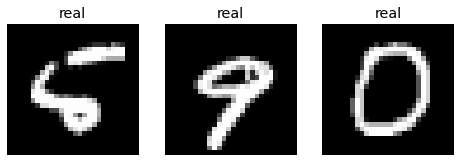

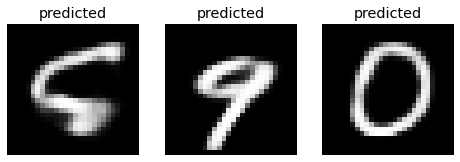

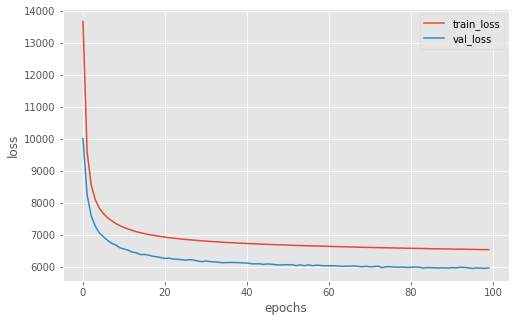

In [ ]:
trainMNIST(vae, optimizer, criterion, 100, train_loader_mnist, val_loader_mnist, device)

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

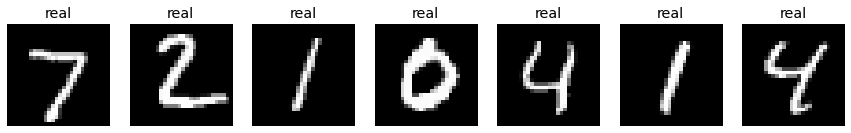

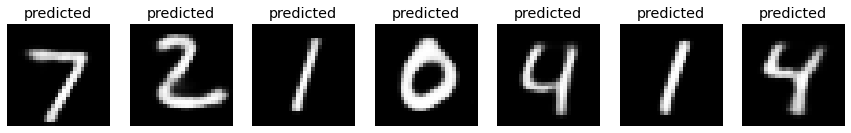

In [ ]:
vae.eval()
real, _ = next(iter(val_loader_mnist))
_, _, pred = vae(real.to(device))
pred = pred.cpu().detach().numpy()
real = real.numpy()

fig, ax = plt.subplots(nrows=1, ncols=7,figsize=(15, 15), sharey=True, sharex=True)
for i, fig_x in enumerate(ax.flatten()):
      real_img = real[i]
      fig_x.set_title('real')
      MNISTshow(real_img, fig_x)
          
fig, ax = plt.subplots(nrows=1, ncols=7,figsize=(15, 15), sharey=True, sharex=True)
for i, fig_x in enumerate(ax.flatten()):
      pred_img = pred[i]
      fig_x.set_title('predicted')
      MNISTshow(pred_img, fig_x)

And finally sample from VAE.

## Sampling

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

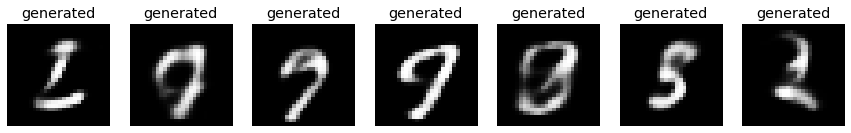

In [ ]:
# вспомните про замечание из этого же пункта обычного AE про распределение латентных переменных
z = torch.Tensor(np.random.normal(0, 1, size=(10, latent_dim)))
output = vae.decode(z.to(device)).cpu().detach().numpy()

fig, ax = plt.subplots(nrows=1, ncols=7,figsize=(15, 15), sharey=True, sharex=True)
for i, fig_x in enumerate(ax.flatten()):
      pred_img = output[i] + np.random.normal(0, 0.2, 1)
      fig_x.set_title('generated')
      MNISTshow(pred_img, fig_x)

## Latent Representation

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве. 

Это позволит оценить, насколько плотно распределены латентные векторы лиц в пространстве. 

Плюс давайте сделаем такую вещь: у вас есть файл с атрибутами lwf_deepfinetuned.txt, который скачался вместе с базой картинок. Там для каждой картинки описаны атрибуты картинки (имя человека, его пол, цвет кожи и т.п.). Когда будете визуализировать точки латентного пространства на картинке, возьмите какой-нибудь атрибут и покрасьте точки в соответствии со значем атрибута, соответствующего этой точке. 

Например, возьмем атрибут "пол". Давайте покрасим точки, которые соответствуют картинкам женщин, в один цвет, а точки, которые соответствуют картинкам мужчин -- в другой.

Подсказка: красить -- это просто =) У plt.scatter есть параметр c (color), см. в документации.


Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю TSNE (есть в sklearn) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью matplotlib.scatter, покрасить разными цветами точки, соответствующие картинкам с разными атрибутами.

In [ ]:
img = next(iter(train_loader))
latent_repres = autoencoder.encoder(img.float().to(device))

In [ ]:
attrs

In [ ]:
# Скорректируем эмоцию только для женщин 
female = attrs.Male.sort_values(ascending=True)[0: 50].index.tolist()
male = attrs.Male.sort_values(ascending=False)[0: 50].index.tolist()

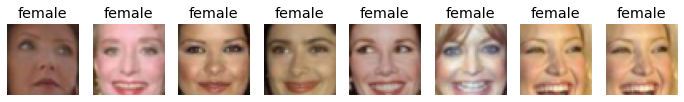

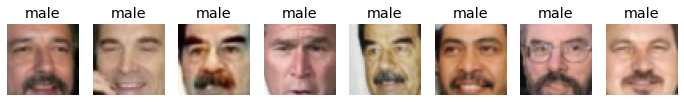

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=8,figsize=(12, 12), sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = np.random.choice(female)
    image = data[random_characters].transpose((1, 2, 0))
    fig_x.axis('off')
    fig_x.set_title("female")
    fig_x.imshow(image)

fig, ax = plt.subplots(nrows=1, ncols=8,figsize=(12, 12), sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = np.random.choice(male)
    image = data[random_characters].transpose((1, 2, 0))
    fig_x.axis('off')
    fig_x.set_title("male")
    fig_x.imshow(image)

In [ ]:
female_tensor = torch.Tensor(data[female]).float().to(device)
female_enc = autoencoder.encoder(female_tensor).cpu().detach().numpy()

male_tensor = torch.Tensor(data[male]).float().to(device)
male_enc = autoencoder.encoder(male_tensor).cpu().detach().numpy()

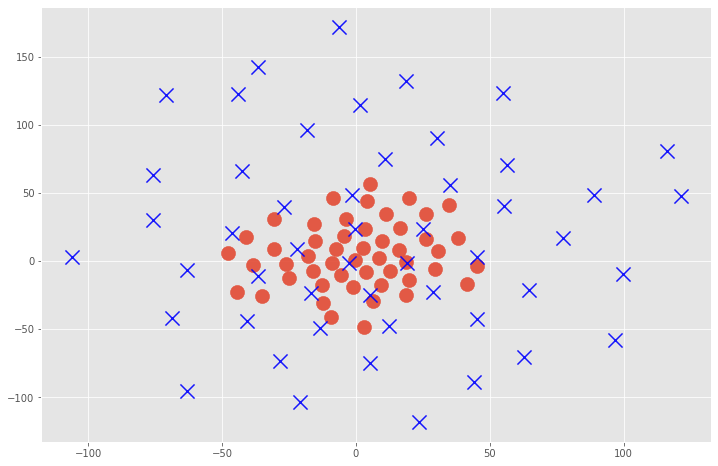

In [ ]:
from sklearn.manifold import TSNE 

female_emb = TSNE(n_components=2).fit_transform(female_enc)
male_emb = TSNE(n_components=2).fit_transform(male_enc)

plt.figure(figsize=(12, 8))
plt.scatter(female_emb[:,0], female_emb[:,1], marker='o', alpha=0.9, s=200)
plt.scatter(male_emb[:,0], male_emb[:,1], color = 'b', marker='x', alpha=0.9, s=200)
plt.show()
# Blue -- men
# Red -- women

Что вы думаете о виде латентного представления?

## Congrats v2.0!

# Conditional VAE (2 балла)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер. 
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица). 
И вот мне понадобилось сгенерировать цифру 8. И я подставляю разные варианты шума, и все никак не генерится восьмерка -- у меня получаются то пятерки, то тройки, то четверки. Гадость(

  Хотелось бы добавить к нашему AE функцию "выдай мне пожалуйста рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).
  Типа я такая говорю "выдай мне случайную восьмерку" и оно генерит случайную восьмерку!

Conditional AE -- так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части проекта мы научимся такие обучать.

## Архитектура

На картинке ниже представлена архитектура простого Conditional AE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки. 

То есть, в первый (входной) слой энкодера есть конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). Первый слой декодера есть конкатенация латентного вектора и информации о классе.


![alt text](https://i.ibb.co/2tsWknB/Screen-Shot-2020-01-15-at-9-02-15-PM.png)



На всякий случай: это VAE, то есть, latent у него состоит из mu и sigma все еще.

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

### P.S.
Можно ередавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

### Датасет
Здесь я предлагаю вам два вариана. Один попроще, другой -- посложнее, но поинтереснее =)

1. Использовать датасет MNIST (http://yann.lecun.com/exdb/mnist/). Обучать conditional VAE на этом датасете, condition -- класс цифры. 

2. Использовать датасет лиц, с которым мы игрались выше. Condition -- пол/раса/улыбки/whatever из lfw_deepfinetuned.txt. 

Почему второй вариант "посложнее" -- потому что я сама еще не знаю, получится ли такой CVAE с лицами или нет =) Вы -- исследователи! (не ну это же проект, так и должно быть)

In [ ]:
<тут ваш код объявления CVAE, лосса, оптимизатора и тренировки>

## Sampling


Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора картинки цифры 5 и 7, а для лиц людей -- восстановить лицо улыбающегося и хмурого человека или лица людей разного пола (смотря на чем был ваш кондишен)

In [ ]:
<тут нужно научиться сэмплировать из декодера цифры определенного класса>

Splendid! Вы великолепны!

Ну круто же, ну?

## Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

In [ ]:
<ваш код получения латентных представлений, применения TSNE и визуализации>

Что вы думаете насчет этой картинки? Отличается от картинки для VAE?

# BONUS 1: Image Morphing (1 балл)  ----  done

<a href="https://ibb.co/rxr9YgL"><img src="https://i.ibb.co/D92dhN6/1-6y-Okto2-BUp-ONJpk5x-LRMtw.png" alt="1-6y-Okto2-BUp-ONJpk5x-LRMtw" border="0"></a>

Предлагаю вам поиграться не только с улыбками, но и с получением из одного человека другого!

План:
1. Берем две картинки разных людей из датасета
2. Получаем их латентные представления X и Y
3. Складываем латентные представления с коэффициентом $\alpha$:
  $$\alpha X + (1-\alpha) Y$$
  где $\alpha$ принимает несколько значений от 0 до 1 
4. Визуализируем, как один человек превращается в другого!

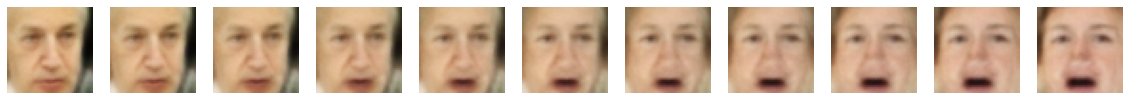

In [ ]:
batch = next(iter(train_loader))
n = int(np.random.randint(0, 256))
m = int(np.random.randint(0, 256))
pic1 = batch[n].reshape((1, 3, 45, 45)).float().to(device)
pic2 = batch[m].reshape((1, 3, 45, 45)).float().to(device)
enc1 = autoencoder.encoder(pic1)
enc2 = autoencoder.encoder(pic2)
alpha = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

fig, ax = plt.subplots(nrows=1, ncols=11,figsize=(20, 20), sharey=True, sharex=True)
for a, fig_x in zip(alpha, ax.flatten()):
    new_vector = a * enc1 + (1 - a) * enc2
    out = autoencoder.decoder(new_vector).cpu().detach().numpy()
    out = out.reshape((3, 45, 45)).transpose((1, 2, 0))
    fig_x.axis('off')
    fig_x.imshow(out)
    None

# BONUS 2: Denoising (2 балла)  ----  done

У автоэнкодеров, кроме сжатия и генерации изображений, есть другие практические применения. Про одно из них это бонусное задание.

Автоэнкодеры могут быть использованы для избавления от шума на фотографиях (denoising). Для этого их нужно обучить специальным образом: input картинка будет зашумленной, а выдавать автоэнкодер должен будет картинку без шума. 
То есть, loss-функция AE останется той же (MSE между реальной картинкой и выданной), а на вход автоэнкодеру будет подаваться зашумленная картинка.

<a href="https://ibb.co/YbRJ1nZ"><img src="https://i.ibb.co/0QD164t/Screen-Shot-2020-06-04-at-4-49-50-PM.png" alt="Screen-Shot-2020-06-04-at-4-49-50-PM" border="0"></a>

Для того, чтобы поставить эксперимент, нужно взять ваш любимый датасет (датасет лиц или MSE с прошлых заданий или любой другой) и сделать копию этого датасета с шумом. 

В питоне шум можно добавить так:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


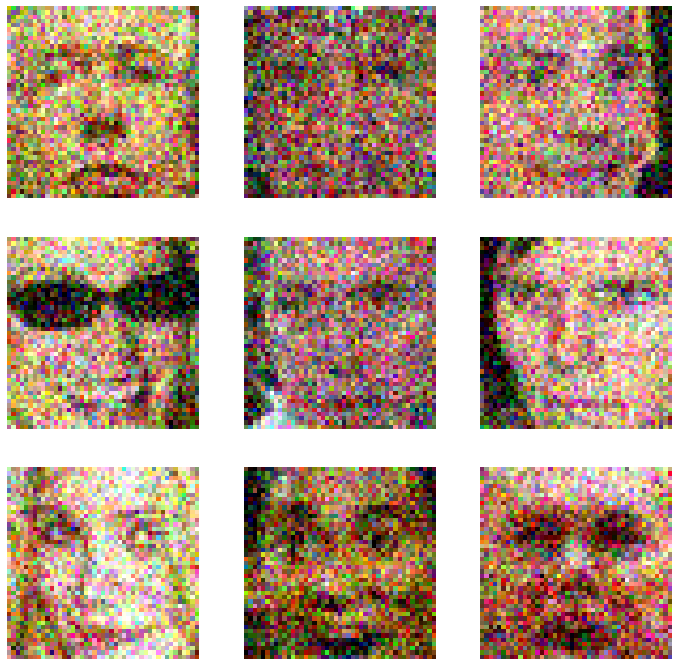

In [ ]:
noise_factor = 0.2
X_noisy = data + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=data.shape) 

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0, 13143))
    image = X_noisy[random_characters].transpose((1, 2, 0))
    fig_x.axis('off')
    fig_x.imshow(image)

In [ ]:
from sklearn.model_selection import train_test_split

batch_size = 256
train_data_n, val_data_n = train_test_split((X_noisy, data), test_size=0.33)
train_loader_n = DataLoader(train_data_n, batch_size=batch_size, shuffle=True)
val_loader_n = DataLoader(val_data_n, batch_size=batch_size, shuffle=True)

In [ ]:
def train_denoise(model, opt, loss_fn, epochs, data_tr, data_val, device):
    train_loss = []
    val_loss = []

    for epoch in range(epochs):
        print('* Epoch %d/%d' % (epoch+1, epochs))

        epoch_loss = 0
        model.train()  # train mode
        for images in data_tr:
            
            noise_factor = 0.1
            images_noise = images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=images.shape) 
            images = images.float().to(device)
            images_noise = images_noise.float().to(device)
            # set parameter gradients to zero
            opt.zero_grad()
            # forward
            Y_pred = model(images_noise)
            loss = loss_fn(Y_pred, images) # forward-pass
            
            loss.backward() # backward-pass
            opt.step()  # update weights

            # calculate loss to show the user
            epoch_loss += loss.item()*images.size(0)
        avg_loss = epoch_loss/len(data_tr)
        train_loss.append(avg_loss)

        model.eval()  # testing mode
        
        image_val = next(iter(data_val)).float()
        val_images_noise = image_val + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=image_val.shape) 

        image_val = image_val.to(device)
        val_images_noise = val_images_noise.float().to(device)

        prediction = model(val_images_noise)
        v_loss = loss_fn(prediction, image_val).item()*image_val.size(0)
        val_loss.append(v_loss)

        print('train_loss: %f' % avg_loss, 'val_loss: %f' % v_loss)

        # Visualize tools
        if (epoch + 1) % 10 == 0:
          clear_output(wait=True)

          real = image_val.cpu().detach().numpy().transpose((0, 2, 3, 1))
          noised = val_images_noise.cpu().detach().numpy().transpose((0, 2, 3, 1))
          pred = prediction.cpu().detach().numpy().transpose((0, 2, 3, 1))

          fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(8, 8), sharey=True, sharex=True)
          for i, fig_x in enumerate(ax.flatten()):
            real_img = real[i]
            fig_x.axis('off')
            fig_x.set_title('real')
            fig_x.imshow(real_img)
          
          fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(8, 8), sharey=True, sharex=True)
          for i, fig_x in enumerate(ax.flatten()):
            noise_img = noised[i]
            fig_x.axis('off')
            fig_x.set_title('noise')
            fig_x.imshow(noise_img)

          fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(8, 8), sharey=True, sharex=True)
          for i, fig_x in enumerate(ax.flatten()):
            pred_img = pred[i]
            fig_x.axis('off')
            fig_x.set_title('predicted')
            fig_x.imshow(pred_img)

          plt.figure(figsize=(8, 5))
          plt.plot(train_loss, label="train_loss")
          plt.plot(val_loss, label="val_loss")
          plt.legend(loc='best')
          plt.xlabel("epochs")
          plt.ylabel("loss")
          plt.show()

In [ ]:
criterion = nn.MSELoss()
denoise= LINAutoencoder().to(device)

In [ ]:
optimizer = torch.optim.Adam(denoise.parameters(), lr=0.00001)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


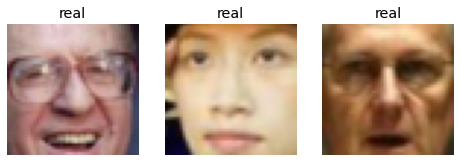

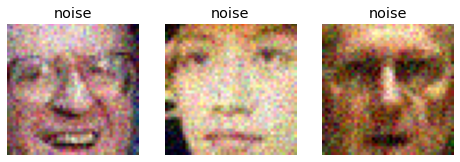

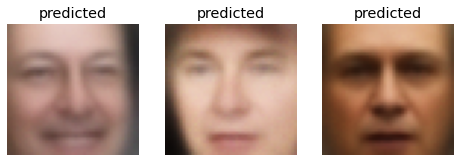

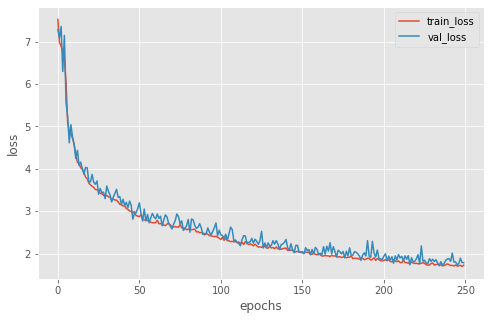

In [ ]:
train_denoise(denoise, optimizer, criterion, 250, train_loader, val_loader, device)

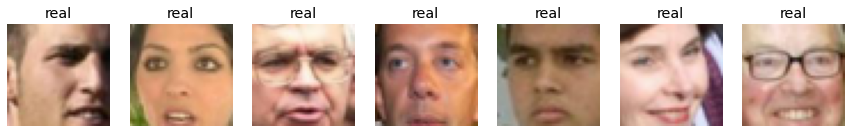

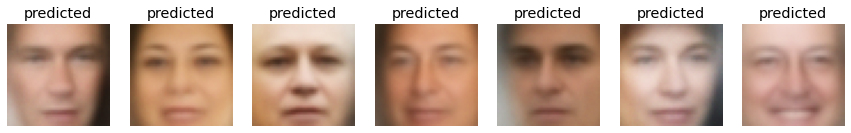

In [ ]:
denoise.eval()
real = next(iter(val_loader))
pred = denoise(real.float().to(device)).cpu().detach().numpy().transpose((0, 2, 3, 1))
real = real.numpy().transpose((0, 2, 3, 1))

fig, ax = plt.subplots(nrows=1, ncols=7,figsize=(15, 15), sharey=True, sharex=True)
for i, fig_x in enumerate(ax.flatten()):
      real_img = real[i]
      fig_x.axis('off')
      fig_x.set_title('real')
      fig_x.imshow(real_img)
          
fig, ax = plt.subplots(nrows=1, ncols=7,figsize=(15, 15), sharey=True, sharex=True)
for i, fig_x in enumerate(ax.flatten()):
      pred_img = pred[i]
      fig_x.axis('off')
      fig_x.set_title('predicted')
      fig_x.imshow(pred_img)

## Бонус 2.1: Occlusion (+еще 1 балл)

<a href="https://imgbb.com/"><img src="https://i.ibb.co/wYrKtQY/Screen-Shot-2020-06-04-at-5-06-35-PM.png" alt="Screen-Shot-2020-06-04-at-5-06-35-PM" border="0" width="300" height="300"></a>

Автоэнкодерами можно не только убирать шум, но и восстанавливать части картинки, которые чем-то закрыты! 

Эксперимент здесь такой: вместо наложения шума на картинку, "закрываем" часть картинки заплаткой и тренируем AE/VAE восстанавливать закрытую часть картинки.

Важно, чтобы заплатка была не очень большая. 

In [ ]:
real = next(iter(val_loader)).numpy()

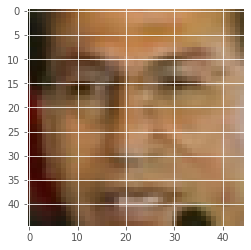

In [ ]:
plt.imshow(real[0].transpose(1, 2, 0))

In [ ]:
from copy import deepcopy

In [ ]:
def trouble_maker(batch):
  batch_inner = deepcopy(batch)
  for image in batch_inner:
    x, y = np.random.randint(9, 35, 2)
    l, h = np.random.randint(6, 45 - 35, 2)

    for i in range(l):
      for j in range(h):
        for c in range(3):
          image[c, x+i, y+j] = 1
  return batch_inner

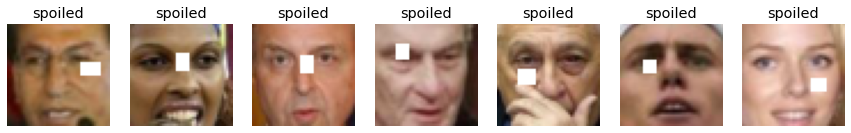

In [ ]:
troubled = trouble_maker(real)

fig, ax = plt.subplots(nrows=1, ncols=7,figsize=(15, 15), sharey=True, sharex=True)
for i, fig_x in enumerate(ax.flatten()):
      real_img = troubled[i]
      fig_x.axis('off')
      fig_x.set_title('spoiled')
      fig_x.imshow(real_img.transpose((1, 2, 0)))

In [ ]:
def train_CCC(model, opt, loss_fn, epochs, data_tr, data_val, device):
    train_loss = []
    val_loss = []

    for epoch in range(epochs):
        print('* Epoch %d/%d' % (epoch+1, epochs))

        epoch_loss = 0
        model.train()  # train mode
        for images in data_tr:
            
            images_noise = trouble_maker(images)

            images = images.float().to(device)
            images_noise = images_noise.float().to(device)
            # set parameter gradients to zero
            opt.zero_grad()
            # forward
            Y_pred = model(images_noise)
            loss = loss_fn(Y_pred, images) # forward-pass
            
            loss.backward() # backward-pass
            opt.step()  # update weights

            # calculate loss to show the user
            epoch_loss += loss.item()*images.size(0)
        avg_loss = epoch_loss/len(data_tr)
        train_loss.append(avg_loss)




        # testing mode
        model.eval()  
        
        image_val = next(iter(data_val)).float()
        
        image_val = image_val.to(device)
        val_images_noise = trouble_maker(image_val).float().to(device)


        prediction = model(val_images_noise)
        v_loss = loss_fn(prediction, image_val)*images.size(0)
        val_loss.append(v_loss)

        print('train_loss: %f' % avg_loss, 'val_loss: %f' % v_loss)

        # Visualize tools
        if (epoch + 1) % 10 == 0:
          clear_output(wait=True)

          real = image_val.cpu().detach().numpy().transpose((0, 2, 3, 1))
          noised = val_images_noise.cpu().detach().numpy().transpose((0, 2, 3, 1))
          pred = prediction.cpu().detach().numpy().transpose((0, 2, 3, 1))

          fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(8, 8), sharey=True, sharex=True)
          for i, fig_x in enumerate(ax.flatten()):
            real_img = real[i]
            fig_x.axis('off')
            fig_x.set_title('real')
            fig_x.imshow(real_img)
          
          fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(8, 8), sharey=True, sharex=True)
          for i, fig_x in enumerate(ax.flatten()):
            noise_img = noised[i]
            fig_x.axis('off')
            fig_x.set_title('noise')
            fig_x.imshow(noise_img)

          fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(8, 8), sharey=True, sharex=True)
          for i, fig_x in enumerate(ax.flatten()):
            pred_img = pred[i]
            fig_x.axis('off')
            fig_x.set_title('predicted')
            fig_x.imshow(pred_img)

          plt.figure(figsize=(8, 5))
          plt.plot(train_loss, label="train_loss")
          plt.plot(val_loss, label="val_loss")
          plt.legend(loc='best')
          plt.xlabel("epochs")
          plt.ylabel("loss")
          plt.show()

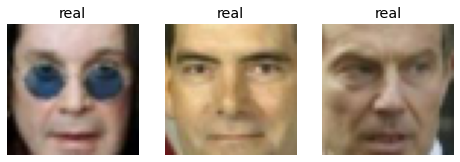

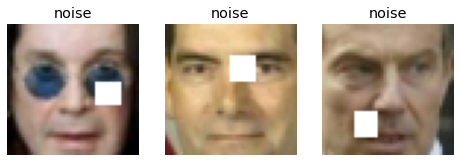

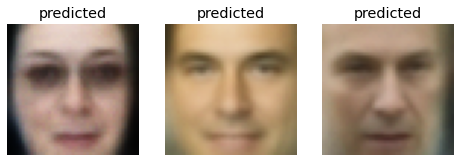

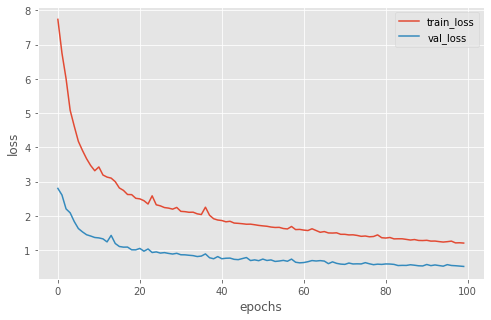

In [ ]:
criterion = nn.MSELoss()
trouble= LINAutoencoder().to(device)
optimizer = torch.optim.Adam(trouble.parameters(), lr=0.0001)
train_CCC(trouble, optimizer, criterion, 100, train_loader, val_loader, device)

In [ ]:
x = next(iter(val_loader))
x = trouble_maker(x).float().to(device)
y = trouble(x)
nn.MSELoss()(y, x).item()

0.012566087767481804

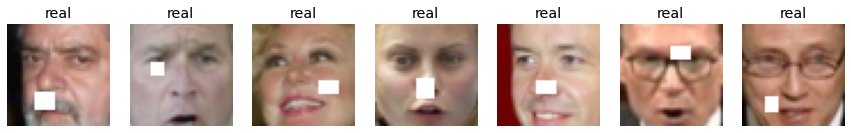

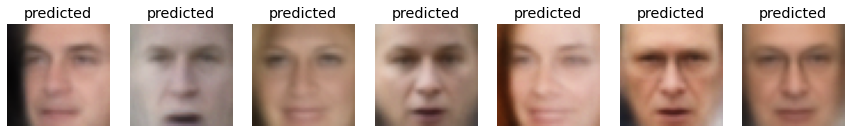

In [ ]:
trouble.eval()
real = next(iter(val_loader))
real = trouble_maker(real)
pred = trouble(real.float().to(device)).cpu().detach().numpy().transpose((0, 2, 3, 1))
real = real.numpy().transpose((0, 2, 3, 1))

fig, ax = plt.subplots(nrows=1, ncols=7,figsize=(15, 15), sharey=True, sharex=True)
for i, fig_x in enumerate(ax.flatten()):
      real_img = real[i]
      fig_x.axis('off')
      fig_x.set_title('real')
      fig_x.imshow(real_img)
          
fig, ax = plt.subplots(nrows=1, ncols=7,figsize=(15, 15), sharey=True, sharex=True)
for i, fig_x in enumerate(ax.flatten()):
      pred_img = pred[i]
      fig_x.axis('off')
      fig_x.set_title('predicted')
      fig_x.imshow(pred_img)

# Bonus 3: Image Retrieval (1 балл)

Давайте представим, что весь наш тренировочный датасет -- это большая база данных людей. И вот мы получили картинку лица какого-то человека с уличной камеры наблюдения (у нас это картинка из тестового датасета) и хотим понять, что это за человек. Что нам делать? Правильно -- берем наш VAE, кодируем картинку в латентное представление и ищем среди латентныз представлений лиц нашей базы самые ближайшие!

План:

1. Получаем латентные представления всех лиц тренировочного датасета
2. Обучаем на них LSHForest (sklearn.neighbors.LSHForest), например, с n_estimators=50
3. Берем картинку из тестового датасета, с помощью VAE получаем ее латентный вектор
4. Ищем с помощью обученного LSHForest ближайшие из латентных представлений тренировочной базы
5. Находим лица тренировочного датасета, которым соответствуют ближайшие латентные представления, визуализируем!

Немного кода вам в помощь: (feel free to delete everything and write your own)

In [ ]:
codes = <поучите латентные представления картинок из трейна>

In [ ]:
# обучаем LSHForest
from sklearn.neighbors import LSHForest
lshf = LSHForest(n_estimators=50).fit(codes)

In [ ]:
def get_similar(image, n_neighbors=5):
  # функция, которая берет тестовый image и с помощью метода kneighbours у LSHForest ищет ближайшие векторы
  # прогоняет векторы через декодер и получает картинки ближайших людей

  code = <получение латентного представления image>
    
  (distances,),(idx,) = lshf.kneighbors(code, n_neighbors=n_neighbors)

  return distances, X_train[idx]

In [ ]:
def show_similar(image):

  # функция, которая принимает тестовый image, ищет ближайшие к нему и визуализирует результат
    
    distances,neighbors = get_similar(image,n_neighbors=11)
    
    plt.figure(figsize=[8,6])
    plt.subplot(3,4,1)
    plt.imshow(image.cpu().numpy().transpose([1,2,0]))
    plt.title("Original image")
    
    for i in range(11):
        plt.subplot(3,4,i+2)
        plt.imshow(neighbors[i].cpu().numpy().transpose([1,2,0]))
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

In [ ]:
<тут выведите самые похожие лица к какому-нибудь лицу из тестовой части датасета>

# Bonus 4: Телеграм-бот (3 балла)

Вы можете написать телеграм-бота с функционалом AE. Например, он может добавлять к вашей фотографии улыбку или искать похожие на ваше лицо лица среди лиц датасета. 

Код бота должно быть можно проверить!

# Эпилог

здесь мы рассмотрели не все применения автоэнкодеров. Еще есть, например:

-- поиск аномалий
-- дополнение отсутствующих частей картины
-- работа с sequential данными (например, временными рядами)
-- гибриды ГАН+АЕ, которые активно изучаются в последнее время
-- использование латентных переменных АЕ в качестве фичей
...

Они не были частью этого проекта, потому что для их реализации пришлось бы больше возиться с датасетами. 

Но! Если вы хотите, вы, конечно, всегда можете реализовать еще что-то и получить за это еще допбаллы.

Надеюсь, вам понравилось!